In [1]:
from OF_trigger import *
from trace_IO import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

sampling_frequency = 3906250
template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

Loading noise traces (0 eV)...


Processing noise sets: 100%|██████████| 100/100 [00:07<00:00, 13.02it/s]



Loading signal traces (25 eV)...


Processing 25 eV signal sets: 100%|██████████| 100/100 [00:07<00:00, 13.16it/s]



Loading signal traces (50 eV)...


Processing 50 eV signal sets: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]



Loading signal traces (75 eV)...


Processing 75 eV signal sets: 100%|██████████| 100/100 [00:07<00:00, 13.09it/s]



Loading signal traces (100 eV)...


Processing 100 eV signal sets: 100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


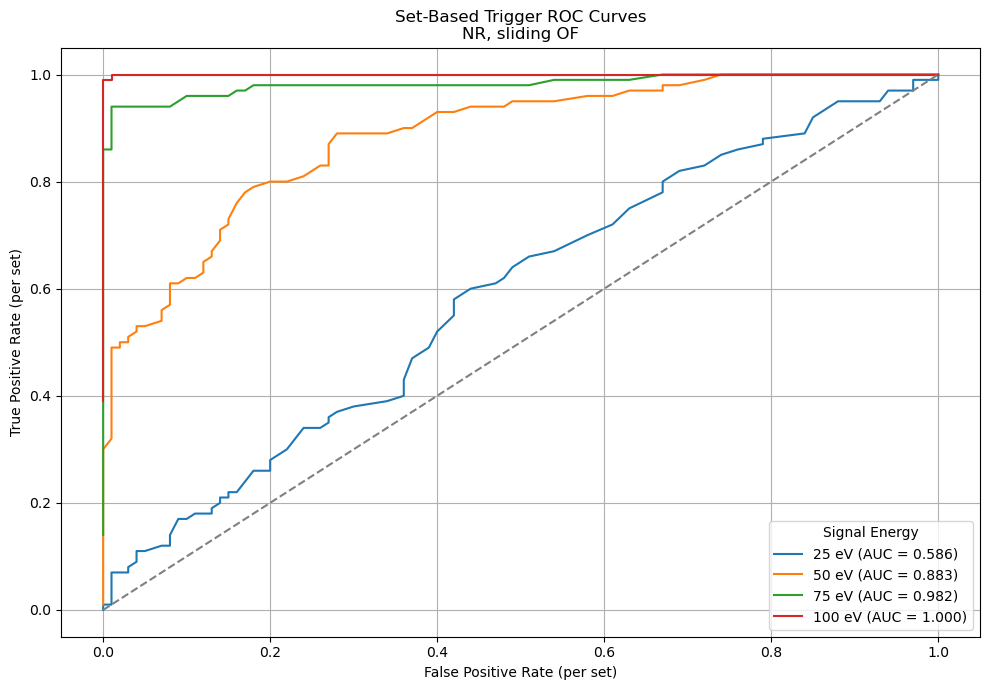

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tqdm import tqdm

# Parameters
signal_energies = [25, 50, 75, 100]  # eV
n_noise_sets = 100
n_signal_sets = 100
traces_per_set = 54

# --- Load noise (0 eV) once ---
print("Loading noise traces (0 eV)...")
noise_traces = load_traces_from_zstd("/ceph/dwong/trigger_samples/ER/traces_energy_0.zst", n_traces=n_noise_sets)
noise_max_amplitudes = []
for traces in tqdm(noise_traces, desc="Processing noise sets"):
    amps = [trigger.fit_with_shift(trace)[0] for trace in traces]
    noise_max_amplitudes.append(np.max(amps))
noise_max_amplitudes = np.array(noise_max_amplitudes)

# --- Prepare threshold sweep ---
thresholds = np.linspace(0, 6, 500)

plt.figure(figsize=(10, 7))

# --- Process each signal energy ---
for signal_energy in signal_energies:
    print(f"\nLoading signal traces ({signal_energy} eV)...")
    signal_traces = load_traces_from_zstd(f"/ceph/dwong/trigger_samples/NR/traces_energy_{signal_energy}.zst", n_traces=n_signal_sets)
    signal_max_amplitudes = []
    for traces in tqdm(signal_traces, desc=f"Processing {signal_energy} eV signal sets"):
        amps = [trigger.fit_with_shift(trace)[0] for trace in traces]
        signal_max_amplitudes.append(np.max(amps))
    signal_max_amplitudes = np.array(signal_max_amplitudes)

    # Compute ROC
    tpr = []
    fpr = []
    for th in thresholds:
        tpr.append(np.sum(signal_max_amplitudes > th) / n_signal_sets)
        fpr.append(np.sum(noise_max_amplitudes > th) / n_noise_sets)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Finalize plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (per set)')
plt.ylabel('True Positive Rate (per set)')
plt.title('Set-Based Trigger ROC Curves\nNR, sliding OF')
plt.legend(title='Signal Energy')
plt.grid(True)
plt.tight_layout()
plt.show()
